In [1]:
from imblearn.over_sampling import SMOTE
import sklearn as sk
from sklearn.neural_network import MLPClassifier
import random as rnd
import matplotlib.pyplot as plt
import joblib
import dataframe_image as dfi
import seaborn as sns

First we will run a python script that that loads, preprocesses and introduce new variable to the dataset. 
The output is a single `df` object.

In [2]:
%run -i src/data_preproc.py

Reading file: orbis_active_be.xlsx ...
Reading file: orbis_active_de.xlsx ...
Reading file: orbis_active_dk.xlsx ...
Reading file: orbis_active_es.xlsx ...
Reading file: orbis_active_fin.xlsx ...
Reading file: orbis_active_fra.xlsx ...
Reading file: orbis_active_it.xlsx ...
Reading file: orbis_active_no.xlsx ...
Reading file: orbis_active_rest.xlsx ...
Reading file: orbis_active_se.xlsx ...
Reading file: orbis_default.xlsx ...


As we can see below there is an imbalance of target variable not only on a single variable but also within countries.
E.G, despite Italy and France, having similar amount of non-default observations, the number of defaulted is way higher for Italy.

This is not only a simple sampling error, but could have an effect on the ML models, as they will learn to identify e.g. Italian corporates as default, despite the fact that location plays not that big role.

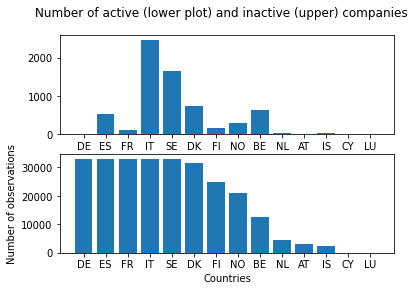

In [3]:
barplot_df = (df
            .groupby('country')['Inactive']
            .agg([('n_inactive', lambda x: np.sum(x == 1)), 
                  ('n_active', lambda x: np.sum(x == 0))]).\
            pipe(lambda df: df.assign(inactive_share = lambda column: column.n_inactive / (column.n_active + column.n_inactive)))
            .reset_index()
            .sort_values(by='n_active', ascending=False))

fig, axs = plt.subplots(2)
fig.suptitle('Number of active (lower plot) and inactive (upper) companies')
axs[0].bar(barplot_df.country, barplot_df.n_inactive)
axs[1].bar(barplot_df.country, barplot_df.n_active)
plt.xlabel("Countries")
plt.ylabel("Number of observations")
plt.savefig('latex/img/country_n.png', dpi=150)

The variables are more or less uncorrelated, with some exceptions. Nonetheless, it does not look like feature selection or dimensionality reduction will provide much value-added.

<AxesSubplot:>

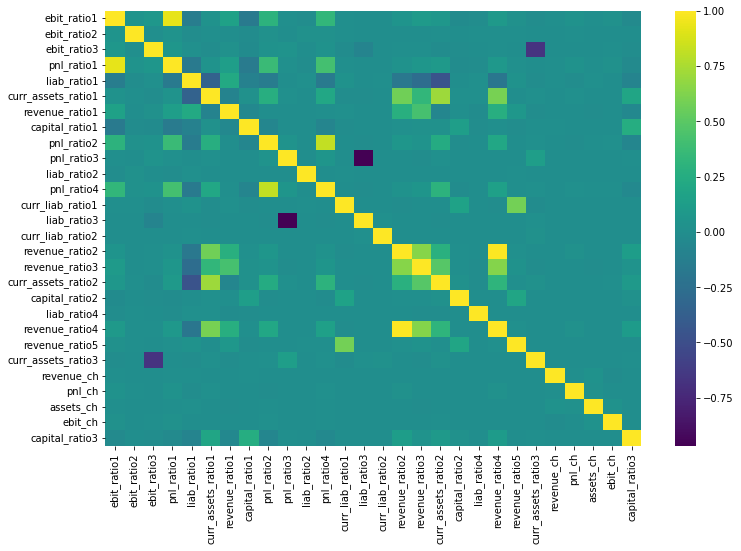

In [4]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.loc[:, df.columns.str.contains('ratio|ch')].dropna().apply(pd.to_numeric).corr(), cmap='viridis')

In the `data_preproc.py` file I deleted some variables with too much `NAs`. Still there are some of them left, that's why we will impute them later on.

In [5]:
# NAs share among original variables
(df.loc[:, ~df.columns.str.contains('ratio|ch|sector_|lag')].isna().sum() / df.shape[0]).sort_values(ascending=False)[:10]

revenue         0.209211
lt_debt         0.121432
cash            0.089731
capital         0.056358
sector          0.051112
ebit            0.046152
fixed_assets    0.046049
assets_log      0.046042
assets          0.046042
curr_liab       0.046038
dtype: float64

### splitting dataset into training/test

In [6]:
split_share = 0.8

rnd.seed(1)
train_id = rnd.sample(range(df.shape[0]), round(df.shape[0] * split_share))

train_df = df.drop(['country', 'last_year', 'sector'], axis=1).loc[train_id]
test_df  = df.drop(['country', 'last_year', 'sector'], axis=1).loc[~np.isin(list(range(df.shape[0])), train_id)]

### Data imputation with median of a given variable

Because of the limitations to the computational capabilites, I abstained from model-based imputation.

In [7]:
for variable in train_df.loc[:, train_df.apply(lambda x: any(x.isna()))].columns:
    train_df.loc[train_df[variable].isna(), variable] = train_df[variable].median()
    test_df.loc[test_df[variable].isna(), variable] = test_df[variable].median()


### Stratified resampling

As noted preiously, there is not only an imbalance of classes per se, but also within location of observations.
To adress this issue, we:

- Get the distribution of defaults for each of the country
- scaled it to get the desired probabilites vector for further resampling
- During resampling, I've resampled with the probability weights, so that the dataset is balanced between countries

In [8]:
cntry = df.country.unique()

cntry_w = train_df.groupby('Inactive')[cntry]\
            .sum()\
            .transpose()\
            .assign(share = lambda x: x[1] / (x[0] + x[1]),
                    rev_share = lambda x: np.where(x[1] == 0, 10, 1/x['share']),
                    p = lambda x: (x['rev_share'] - np.min(x['rev_share'])) / (np.max(x['rev_share']) - np.min(x['rev_share'])))\
            .reset_index(level=0)\
            .rename(columns={'index': 'country'})

In [9]:
rnd.seed(1)

train_id = rnd.sample(range(df.shape[0]), round(df.shape[0] * split_share))

sample_p = df.drop(['last_year', 'sector'], axis=1)\
            .loc[train_id]\
            .reset_index(drop=True)\
            .merge(cntry_w[['country', 'share']], on = 'country', how = 'left')

sample_p_us = sample_p[sample_p.Inactive == 0].share
sample_p_os = sample_p.query(('DE == 0 & Inactive == 1')).share
sample_p_us = sample_p_us /sum(sample_p_us)
sample_p_os = np.where(sample_p_os == 0, 0, (1/sample_p_os /sum(1/sample_p_os)))

### Resampling strategy

To adress the problem of imbalance among default and non-default observations, I have tried 3 resampling strategies:
- undersampling
- oversampling
- SMOTE + undersampling 

In [10]:
np.random.seed(1)

def undersampling(smpl_df, class_variable, rate):
    smpl_df.reset_index(drop=True, inplace = True)
    indexes  = np.random.choice(a    = list(smpl_df[smpl_df[class_variable] == 0].index), 
                                size = round(np.sum(smpl_df[class_variable] == 1) * rate),
                                p = sample_p_us)
    train_df = pd.concat([smpl_df.loc[smpl_df[class_variable] == 1], smpl_df.loc[indexes]])
    return train_df

df_train_us = undersampling(train_df, 'Inactive', 1) # undersampling to 1:1 relation
df_train_sm = undersampling(train_df, 'Inactive', 3) # undersampling to 2:1 relation for SMOTE
X_train_us = df_train_us.loc[:, df_train_us.columns != 'Inactive']
y_train_us = df_train_us.Inactive


In [11]:
X_train_sm, y_train_sm = SMOTE(random_state=1).fit_resample(df_train_sm.loc[:,~np.isin(df_train_sm.columns, 'Inactive')], df_train_sm['Inactive'])

In [12]:
np.random.seed(1)

train_df_os = train_df.query('DE == 0')

os_indexes = np.random.choice(a    = list(train_df_os[train_df_os.Inactive == 1].index), 
                              size = np.sum(train_df_os.Inactive == 0) - np.sum(train_df_os.Inactive == 1),
                              p = sample_p_os)
train_df_os = pd.concat([train_df_os.loc[os_indexes,:], train_df_os])

X_train_os = train_df_os.loc[:, train_df_os.columns != 'Inactive']
y_train_os = train_df_os.Inactive

In [13]:
{'SMOTE n observations': y_train_sm.shape[0],
 'Undersampling n observations': y_train_us.shape[0],
 'Oversampling n observations': y_train_os.shape[0]}

{'SMOTE n observations': 32136,
 'Undersampling n observations': 10712,
 'Oversampling n observations': 370834}

As one can see below, the defaulted and nondefaulted observations are more or less balanced between their locations as well as in general sample.

In [14]:
X_train_us.assign(Inactive = y_train_us)\
            .groupby('Inactive')[cntry]\
            .sum()\
            .transpose()\
            .assign(share = lambda x: x[1] / (x[1] + x[0]))

Inactive,0,1,share
BE,532,520,0.494297
DE,0,0,NaN
DK,574,581,0.503030
ES,425,427,0.501174
FI,113,121,0.517094
FR,98,100,0.505051
IT,1927,1983,0.507161
NO,261,237,0.475904
NL,31,34,0.523077
AT,5,3,0.375000


In [15]:
train_df_os.groupby('Inactive')[cntry]\
            .sum()\
            .transpose()\
            .assign(share = lambda x: x[1] / (x[1] + x[0]))

Inactive,0,1,share
BE,10027,10438,0.510042
DE,0,0,NaN
DK,25239,25030,0.497921
ES,26267,25835,0.495854
FI,19836,18894,0.487839
FR,26381,24771,0.484263
IT,26285,28645,0.521482
NO,16787,16358,0.493528
NL,3736,3589,0.489966
AT,2467,2338,0.486576


### Training models

I've trained 3 models to compare in the predictive modeling:
- Lgoistic regression
- XGBoost
- Multilayer perceptron classifier

Each of them had their hyperparameters tuned (although with not too complex optimization sttrategies due to the computational limiations)

They are already pretrained and saved in `models` folder, so it is not necessery to train them again.

In [17]:
#%run -i models/logistic_regression.py 
# approx time: 17 mins

In [18]:
#%run -i models/mlpc.py
# approx time: 42 mins

In [19]:
#%run -i models/xgb.py
# approx. time: 41 mins

In [20]:
# this code chunk loads pretraiend models
# if you wish to train them once again run code chunks above
logit_os = joblib.load('models/logit_os.sav')
logit_us = joblib.load('models/logit_us.sav')
logit_sm = joblib.load('models/logit_sm.sav')

mlpc_us = joblib.load('models/mlpc_us.sav')
mlpc_os = joblib.load('models/mlpc_os.sav')
mlpc_sm = joblib.load('models/mlpc_sm.sav')

xgb_us = joblib.load('models/xgb_us.sav')
xgb_os = joblib.load('models/xgb_os.sav')
xgb_sm = joblib.load('models/xgb_sm.sav')

Script below loads a metrics class, that will help us investigating performance of the models

In [21]:
%run -i "src/pred_metrics_class.py"

### ROC curves

First ROC curve is of the logistic regression. Apparently, this model did not converge at all. Perhaps the dataset have a too complicated/non-linear patterns.

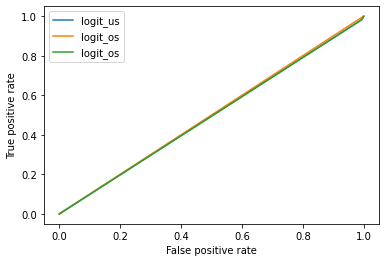

In [22]:
metrics_logit_us = PredMetrics(pred_pd = logit_us.predict_proba(test_df.loc[:,test_df.columns != 'Inactive'])[:,1],
                       actual = np.array(test_df.Inactive))
metrics_logit_os = PredMetrics(pred_pd = logit_os.predict_proba(test_df.loc[:,test_df.columns != 'Inactive'])[:,1],
                       actual = np.array(test_df.Inactive))
metrics_logit_sm = PredMetrics(pred_pd = logit_sm.predict_proba(test_df.loc[:,test_df.columns != 'Inactive'])[:,1],
                       actual = np.array(test_df.Inactive))

thresholds = np.linspace(start=0, stop=1, num=1000)

labels = ['logit_us', 'logit_os', 'logit_sm']
n = 0

for model in [metrics_logit_us, metrics_logit_os, metrics_logit_sm]:
    fpr = [model.fpr(i) for i in thresholds]
    tpr = [model.tpr(i) for i in thresholds]
    plt.plot(fpr, tpr, label = labels[n])
    n =+ 1

plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.savefig('latex/img/log_roc.png', dpi=150)
plt.show()

The ROC curve for the XGBoost mdoel shows a fairly good fit to the dataset. The difference between resampling strategies are not big, but shows, surprisingly, that the most complicated method did not provide any value-added (quite contrary!). 

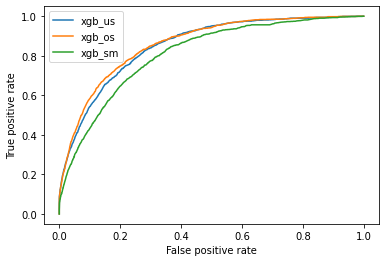

In [23]:
metrics_xgb_us = PredMetrics(pred_pd = xgb_us.predict_proba(np.array(test_df.loc[:,test_df.columns != 'Inactive']))[:,1],
                       actual = np.array(test_df.Inactive))
metrics_xgb_os = PredMetrics(pred_pd = xgb_os.predict_proba(np.array(test_df.loc[:,test_df.columns != 'Inactive']))[:,1],
                       actual = np.array(test_df.Inactive))
metrics_xgb_sm = PredMetrics(pred_pd = xgb_sm.predict_proba(np.array(test_df.loc[:,test_df.columns != 'Inactive']))[:,1],
                       actual = np.array(test_df.Inactive))

thresholds = np.linspace(start=0, stop=1, num=1000)

labels = ['xgb_us', 'xgb_os', 'xgb_sm']
n = 0

for model in [metrics_xgb_us, metrics_xgb_os, metrics_xgb_sm]:
    fpr = [model.fpr(i) for i in thresholds]
    tpr = [model.tpr(i) for i in thresholds]
    plt.plot(fpr, tpr, label = labels[n])
    n += 1

plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.savefig('latex/img/xgb_roc.png', dpi=150)
plt.show()

For the MLPC model, the fit is slightly worse, althoug noticeable. What's interesting for the model is the difference in TPR-TNR trade-off for each of the strategy. SMOTE lacks, on finding true positives but have a similar ability to detect negatives as other resampling stratgies. 
Undersamplign seems to be the most balanced when it comes to the trade-off and intrestingly, the oversampling is good for detecting positives but is being worse for the TNR with respect to other models.

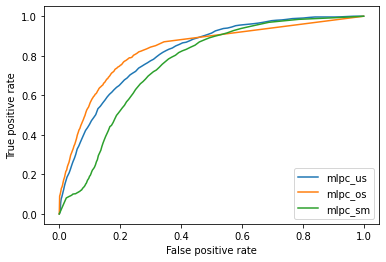

In [24]:
scaler = sk.preprocessing.StandardScaler()

def scale_test(X_train, X_test):
    scaler.fit(X_train)  
    X_test_scaled = scaler.transform(X_test)
    return X_test_scaled

X_test_os = scale_test(X_train_os, test_df.loc[:,test_df.columns != 'Inactive'])
X_test_us = scale_test(X_train_us, test_df.loc[:,test_df.columns != 'Inactive'])
X_test_sm = scale_test(X_train_sm, test_df.loc[:,test_df.columns != 'Inactive'])

metrics_mlpc_us = PredMetrics(pred_pd = mlpc_us.predict_proba(X_test_us)[:,1],
                       actual = np.array(test_df.Inactive))
metrics_mlpc_os = PredMetrics(pred_pd = mlpc_os.predict_proba(X_test_os)[:,1],
                       actual = np.array(test_df.Inactive))
metrics_mlpc_sm = PredMetrics(pred_pd = mlpc_sm.predict_proba(X_test_sm)[:,1],
                       actual = np.array(test_df.Inactive))

thresholds = np.linspace(start=0, stop=1, num=100)

labels = ['mlpc_us', 'mlpc_os', 'mlpc_sm']
n = 0

for model in [metrics_mlpc_us, metrics_mlpc_os, metrics_mlpc_sm]:
    fpr = [model.fpr(i) for i in thresholds]
    tpr = [model.tpr(i) for i in thresholds]
    plt.plot(fpr, tpr, label = labels[n])
    n += 1

plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.savefig('latex/img/mlpc_roc.png', dpi=150)
plt.show()

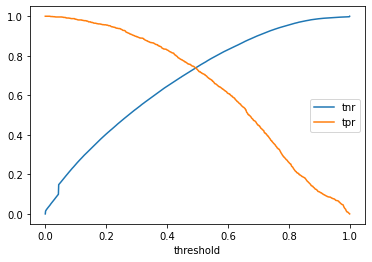

<Figure size 432x288 with 0 Axes>

In [25]:
thresholds = np.linspace(start=0, stop=1, num=1000)

tnr = [metrics_mlpc_us.tnr(i) for i in thresholds]
tpr = [metrics_mlpc_us.tpr(i) for i in thresholds]

plt.plot(thresholds, tnr, label = "tnr")
plt.plot(thresholds, tpr, label = "tpr")
plt.legend()
plt.xlabel('threshold')
plt.show()
plt.savefig('latex/img/mlpc_tnr_tpr.png', dpi=150)

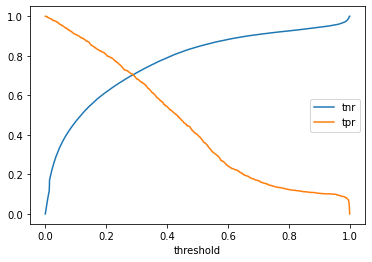

<Figure size 432x288 with 0 Axes>

In [26]:
thresholds = np.linspace(start=0, stop=1, num=1000)

tnr = [metrics_mlpc_sm.tnr(i) for i in thresholds]
tpr = [metrics_mlpc_sm.tpr(i) for i in thresholds]

plt.plot(thresholds, tnr, label = "tnr")
plt.plot(thresholds, tpr, label = "tpr")
plt.legend()
plt.xlabel('threshold')
plt.show()
plt.savefig('latex/img/mlpc_tnr_tpr.png', dpi=150)

In [27]:
model_metrics = {
    'logit_os': metrics_logit_os,
    'logit_us': metrics_logit_us,
    'logit_sm': metrics_logit_sm,
    'xgb_us': metrics_xgb_us,
    'xgb_os': metrics_xgb_os,
    'xgb_sm': metrics_xgb_sm,
    'mlpc_us': metrics_mlpc_us,
    'mlpc_os': metrics_mlpc_os,
    'mlpc_sm': metrics_mlpc_sm
}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


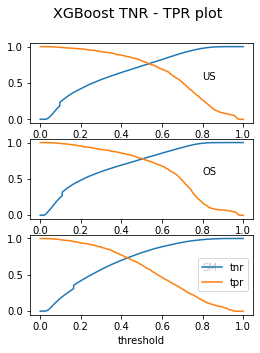

In [28]:
xgb_metrics = {
    'xgb_us': metrics_xgb_us,
    'xgb_os': metrics_xgb_os,
    'xgb_sm': metrics_xgb_sm}

fig, axs = plt.subplots(3)
fig.suptitle('XGBoost TNR - TPR plot', size = 'x-large')

plot = 0
thresholds = np.linspace(start=0, stop=1, num=1000)

for metric in xgb_metrics.keys():
    tnr = [xgb_metrics[metric].tnr(i) for i in thresholds]
    tpr = [xgb_metrics[metric].tpr(i) for i in thresholds]  
    axs[plot].plot(thresholds, tnr, label = "tnr")
    axs[plot].plot(thresholds, tpr, label = "tpr")
    plt.xlabel('threshold')
    plt.legend()
    axs[plot].text(0.8, 0.55, s = str(metric).replace('xgb_', '').upper(), fontsize=10)
    plot += 1

fig.set_size_inches(4, 5)
plt.savefig('latex/img/xgb_tnr_tpr.png', dpi=200)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


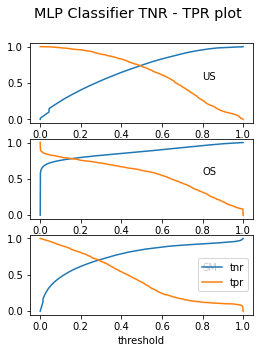

In [29]:
mlpc_metrics = {
    'mlpc_us': metrics_mlpc_us,
    'mlpc_os': metrics_mlpc_os,
    'mlpc_sm': metrics_mlpc_sm}

fig, axs = plt.subplots(3)
fig.suptitle('MLP Classifier TNR - TPR plot', size = 'x-large')

plot = 0
thresholds = np.linspace(start=0, stop=1, num=1000)

for metric in mlpc_metrics.keys():
    tnr = [mlpc_metrics[metric].tnr(i) for i in thresholds]
    tpr = [mlpc_metrics[metric].tpr(i) for i in thresholds]  
    axs[plot].plot(thresholds, tnr, label = "tnr")
    axs[plot].plot(thresholds, tpr, label = "tpr")
    plt.xlabel('threshold')
    plt.legend()
    axs[plot].text(0.8, 0.55, s = str(metric).replace('mlpc_', '').upper(), fontsize=10)
    plot += 1

fig.set_size_inches(4, 5)
plt.savefig('latex/img/mlpc_tnr_tpr.png', dpi=200)

The table below shows metrics (TPR, TNR and balanced accuracy) that each of the models gets with the optimal (in-sample) threshold.  

In [30]:

max_balance = pd.DataFrame([])

for metric in model_metrics.keys():
    max_balance = pd.concat([max_balance, model_metrics[metric].max_balanced_acc(1000)], axis=1)

max_balance.columns = model_metrics.keys()
max_balance = max_balance.apply(lambda x: x*100).style.background_gradient(axis=None).format('{:.1f} %')

dfi.export(max_balance,"latex/img/max_balance_table.png")

max_balance

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\dataframe_image\_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'


,logit_os,logit_us,logit_sm,xgb_us,xgb_os,xgb_sm,mlpc_us,mlpc_os,mlpc_sm
thresholds,49.9 %,49.0 %,48.9 %,48.7 %,45.6 %,35.4 %,42.2 %,13.8 %,22.0 %
tpr,100.0 %,100.0 %,100.0 %,82.3 %,82.1 %,83.3 %,81.2 %,78.8 %,78.8 %
tnr,0.1 %,0.1 %,0.1 %,72.2 %,73.6 %,64.6 %,66.8 %,77.3 %,63.9 %
balanced_acc,50.0 %,50.0 %,50.0 %,77.3 %,77.8 %,74.0 %,74.0 %,78.0 %,71.3 %


Another table, shows metrics for the base case threshold (50%)

In [31]:
models_balanced_acc = pd.DataFrame({'balanced accuracy': [model_metrics[metric].balanced_acc(0.5) for metric in model_metrics],
                                    'TPR': [model_metrics[metric].tpr(0.5) for metric in model_metrics],
                                    'TNR': [model_metrics[metric].tnr(0.5) for metric in model_metrics],
                                    'FPR': [model_metrics[metric].fpr(0.5) for metric in model_metrics],
                                    'FNR': [model_metrics[metric].fnr(0.5) for metric in model_metrics]})

models_balanced_acc = models_balanced_acc.transpose()
models_balanced_acc.columns = model_metrics

models_balanced_acc = models_balanced_acc.apply(lambda x: x*100).style.format('{:.1f} %')\
    .background_gradient(axis=None).format('{:.1f} %')

dfi.export(models_balanced_acc,"latex/img/balance_acc_table.png")

models_balanced_acc

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\dataframe_image\_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'


,logit_os,logit_us,logit_sm,xgb_us,xgb_os,xgb_sm,mlpc_us,mlpc_os,mlpc_sm
balanced accuracy,59.0 %,52.7 %,56.4 %,77.0 %,77.7 %,72.1 %,73.7 %,74.7 %,62.4 %
TPR,31.4 %,8.1 %,21.2 %,80.7 %,78.1 %,63.8 %,72.9 %,61.8 %,40.2 %
TNR,86.6 %,97.4 %,91.5 %,73.3 %,77.2 %,80.5 %,74.5 %,87.6 %,84.6 %
FPR,13.4 %,2.6 %,8.5 %,26.7 %,22.8 %,19.5 %,25.5 %,12.4 %,15.4 %
FNR,68.6 %,91.9 %,78.8 %,19.3 %,21.9 %,36.2 %,27.1 %,38.2 %,59.8 %


In [32]:
print('Example of interpretation: ')
print('-------------------------')
print('FPR: for an XGBoost model trained on undersampled data (xgb_us), \n the probability of falsely predicting default is: ' + 
str(round(model_metrics['xgb_us'].fpr(0.5), 3) * 100) + "%")
print('-------------------------')
print('TPR: for a Multilayer perceptron model trained on SMOTE data (mlpc_sm), \n the probability of truly predicting default is: ' + 
str(round(model_metrics['mlpc_sm'].tpr(0.5), 3) * 100) + "%")
print('-------------------------')
print('TNR: for a logistic regression model trained on oversampled data (log_os), \n the probability of truly predicting no-default is: ' + 
str(round(model_metrics['mlpc_sm'].tnr(0.5), 3) * 100) + "%")
print('-------------------------')
print('FNR: for an XGBoost model trained on oversampled data (xgb_os), \n the probability of falsely predicting no-default is: ' + 
str(round(model_metrics['mlpc_sm'].fnr(0.5), 3) * 100) + "%")

Example of interpretation: 
-------------------------
FPR: for an XGBoost model trained on undersampled data (xgb_us), 
 the probability of falsely predicting default is: 26.700000000000003%
-------------------------
TPR: for a Multilayer perceptron model trained on SMOTE data (mlpc_sm), 
 the probability of truly predicting default is: 40.2%
-------------------------
TNR: for a logistic regression model trained on oversampled data (log_os), 
 the probability of truly predicting no-default is: 84.6%
-------------------------
FNR: for an XGBoost model trained on oversampled data (xgb_os), 
 the probability of falsely predicting no-default is: 59.8%


### Model interpretation

What follows is the feature importance plot for undersampled XGBoost and MLPC models. What is interesting is the usefullness of the non-processed (or in other words, in levels) variables such as revenue, lagged PNL or assets. Either model found interesting effects of scale that influences the predictability or there is another sampling error I have omitted. 

In [33]:
import dalex as dx
import warnings

warnings.filterwarnings("ignore")
xgb_exp = dx.Explainer(xgb_us, test_df.loc[:,test_df.columns != 'Inactive'].apply(pd.to_numeric), test_df.Inactive, verbose=False)
mlpc_exp = dx.Explainer(mlpc_us, X_test_us, test_df.Inactive, verbose=False)

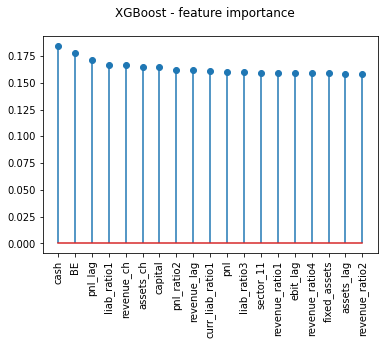

In [34]:
warnings.filterwarnings("ignore")
feat_imp = xgb_exp\
            .model_parts()\
            .result\
            .sort_values('dropout_loss', ascending=False)\
            .iloc[1:20 , :]

plt.stem(feat_imp['dropout_loss'])
plt.xticks(range(0,len(feat_imp.index)), feat_imp.variable, rotation=90)
plt.suptitle('XGBoost - feature importance')
plt.savefig('latex/img/xgb_exp.png', dpi=150, bbox_inches = "tight")

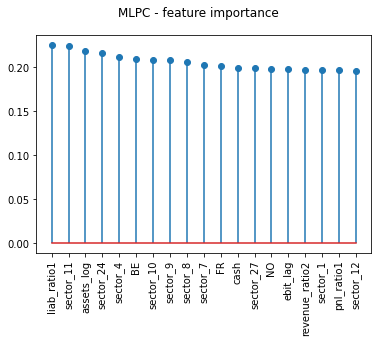

In [35]:
warnings.filterwarnings("ignore")
var_names = pd.DataFrame({'variables_names': test_df.loc[:,test_df.columns != 'Inactive'].columns,
                          'variable': range(len(test_df.loc[:,test_df.columns != 'Inactive'].columns))})
var_names['variable'] = var_names['variable'].astype(int)

mlpc_feat_imp = mlpc_exp\
            .model_parts()\
            .result\
            .sort_values('dropout_loss', ascending=False)\
            .iloc[1:20 , :]
        
mlpc_feat_imp['variable'] = mlpc_feat_imp['variable'].astype(int)
mlpc_feat_imp = mlpc_feat_imp.merge(var_names, on='variable')

plt.stem(mlpc_feat_imp['dropout_loss'])
plt.xticks(range(0,len(mlpc_feat_imp.index)), mlpc_feat_imp.variables_names, rotation=90)
plt.suptitle('MLPC - feature importance')
plt.savefig('latex/img/mlpc_exp.png', dpi=150, bbox_inches = "tight")

### default case

Below we try observation-level diagnostics. The plot shows the variables contributing to the bancruptcy of Energia Siciliana S.R.L, which was one of the biggest distributor of petroleum products in Sicily. The biggest contributors to the default were the low level of cash (in an absolute level), big fall in net profits and revenue.

The model correctly predicted the bancrupcty (out-of-sample!) with the probability of 76,6%


more here: https://catania.meridionews.it/articolo/88624/sentenza-dichiara-il-fallimento-di-sp-energia-siciliana-lazienda-del-cavaliere-pappalardo-travolta-dai-debiti/

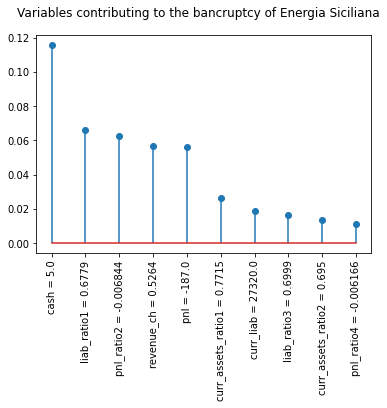

In [36]:
warnings.filterwarnings("ignore")
energia_siciliana = train_df.loc[(train_df.assets == 44741), train_df.columns != 'Inactive'].apply(pd.to_numeric)
pred_parts = xgb_exp.predict_parts(energia_siciliana, type = 'break_down')

ES_plot_df = pred_parts\
                .result\
                .sort_values('contribution', ascending=False)\
                .iloc[2:12 , :]

plt.stem(ES_plot_df['contribution'])
plt.xticks(range(0,len(ES_plot_df.index)), ES_plot_df.variable, rotation=90)
plt.suptitle('Variables contributing to the bancruptcy of Energia Siciliana')
plt.savefig('latex/img/energia_plot.png', dpi=150, bbox_inches = "tight")